In [1]:
import os
os.chdir('../src')

In [2]:
import glob, cv2
from tqdm import tqdm

import numpy as np
import pandas as pd

import sys, os, time, logging, datetime, random
from pathlib import Path

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from config import _C as cfg
from models.create_model import CustomNet

from data_builder import build_valid_loader, build_train_loader
from data_builder.transforms import get_valid_transform, get_test_transform
from models.optimizer import make_optimizer
from models.scheduler import make_scheduler
from models.create_model import CustomNet

#TODO: provare ad usare questo
from models.loss import BiTemperedLogisticLoss

from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [3]:
img_id1 = glob.glob(os.path.join(cfg.DATA_DIR, 'data_2019', '**/*.jpg'))
img_id2 = glob.glob(os.path.join(cfg.DATA_DIR, 'extraimages', '*.jpg'))

img_id = img_id1 + img_id2
df = pd.DataFrame()
df['image_id'] = img_id

In [4]:
class cassavaTest(Dataset):

    def __init__(self, df, cfg, transforms=None, preprocessing=None):

        self.df = df
        self.cfg = cfg
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx:int):
        row = self.df.iloc[idx]
        img_id = row['image_id']

        path_img = img_id

        img = cv2.imread(
            path_img, cv2.IMREAD_COLOR
        )

        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']
        
        return img, img_id

In [5]:
data = cassavaTest(
    df, 
    cfg, 
    transforms=get_test_transform(cfg)
)

In [6]:
dl = DataLoader(
    dataset=data,
    sampler=SequentialSampler(data),
    drop_last=False,
    batch_size=cfg.TRAIN_LOADER.BATCH_SIZE,
    num_workers=cfg.TRAIN_LOADER.NUM_WORKERS,
    pin_memory=True
)

In [7]:
def load_model(cfg):
    checkpoint = torch.load(
        cfg.CHECKPOINT_PATH,
    )
    model = CustomNet(cfg)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(cfg.DEVICE)
    model.eval()
    del checkpoint
    return model

In [8]:
model = load_model(cfg)

In [9]:
predicted_class = []
predicted_prob = []

test_loader = tqdm(dl, total=len(dl))
for cnt, (imgs, ids) in enumerate(test_loader):

    with torch.no_grad():
        imgs = imgs.to(cfg.DEVICE)
        logits = model(imgs)

    preds = F.softmax(logits, -1).detach().cpu().numpy()

    pred_c = np.argmax(a=preds, axis=1)
    pred_p = np.max(a=preds, axis=1)

    predicted_class.append(pred_c)
    predicted_prob.append(pred_p)

100%|██████████| 2282/2282 [06:16<00:00,  6.06it/s]


In [10]:
predicted_class = np.concatenate(predicted_class)
predicted_prob =  np.concatenate(predicted_prob)

In [11]:
df['pred_c'] = predicted_class
df['pred_p'] = predicted_prob

In [12]:
#Plot worst prediction

In [13]:
worst = df[df['pred_p']==df['pred_p'].min()]

In [14]:
im_w = cv2.imread(worst['image_id'].values[0])
im_w = cv2.cvtColor(im_w, cv2.COLOR_BGR2RGB)
im_w = cv2.resize(
    im_w, 
    dsize=(512, 512),
    interpolation=cv2.INTER_AREA
)
#cv2.imshow(f"c:{worst['pred_c'].values[0]}, p: {worst['pred_p'].values[0]}", im_w)

Text(0.5, 1.0, 'c:0, p: 0.2647832930088043')

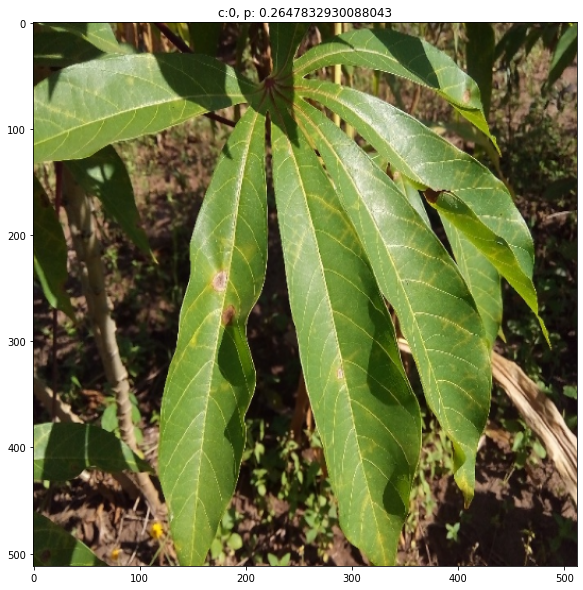

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(im_w)
plt.title(f"c:{worst['pred_c'].values[0]}, p: {worst['pred_p'].values[0]}")


In [16]:
worst['image_id'].values[0]

'/home/giorgio/Scrivania/Kaggle/cassava_leaf/data/data_2019/cbsd/train-cbsd-245.jpg'

In [18]:
best = df[df['pred_p']==df['pred_p'].max()]
im_b = cv2.imread(best['image_id'].values[0])
im_b = cv2.cvtColor(im_b, cv2.COLOR_BGR2RGB)
im_b = cv2.resize(
    im_b, 
    dsize=(512, 512),
    interpolation=cv2.INTER_AREA
)


Text(0.5, 1.0, 'c:0, p: 0.998712420463562')

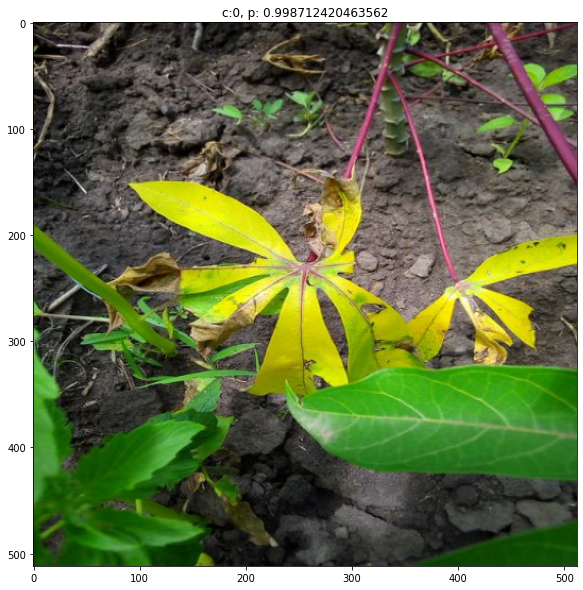

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(im_b)
plt.title(f"c:{best['pred_c'].values[0]}, p: {best['pred_p'].values[0]}")

In [20]:
best['image_id'].values[0]

'/home/giorgio/Scrivania/Kaggle/cassava_leaf/data/extraimages/extra-image-14159.jpg'

In [17]:
df.to_csv('../data/psl_cassava2019.csv', index=False)